In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians

Variáveis globais

In [ ]:
lista_FE = []      # Lista que guarda os DataFrames dos 6 fatores de espalhamento
lista_maior = []   # Lista que guarda os valores da maior distância percorrida pelo fator de espalhamento
path = "/content/drive/MyDrive/dados_colab/PAIC_FAPEAM/dados_rio_negro.xlsx" # Caminho do arquivo que contém os dados

As coordenadas do ponto fixo do receptor em cada fator de espalhamento

In [ ]:
ponto_fixo = pd.read_excel(path, "PONTO_FIXO")
ponto_fixo.index = list(ponto_fixo['identificador'].astype(np.int32))
ponto_fixo.drop(columns = ['identificador'], inplace=True)
ponto_fixo

,fator_espalhamento,latitude,longitude
7,FE7,-3.046820,-60.255283
8,FE8,-3.046820,-60.255283
9,FE9,-3.046373,-60.255376
10,FE10,-3.046373,-60.255376
11,FE11,-3.046373,-60.255376
12,FE12,-3.046373,-60.255376


## Carregamento e tratamento dos dados

In [ ]:
for FE in range(7, 13):
  # Leitura do arquivo em excel
  sheet_name = "FE" + str(FE)
  df = pd.read_excel(path, sheet_name)

  # Removendo colunas desnecessárias
  df.drop(columns = ['Hora GPS', 'F.E', 'Altitude', 'Bytes'], inplace=True)

  # Inserindo a coluna de distância
  df['Distancia'] = -1

  # Modificando para os tipos corretos
  df['Contador'] = df['Contador'].astype(np.int32)
  df['RSSI'] = df['RSSI'].astype(np.int32)
  df['Distancia'] = df['Distancia'].astype(np.float64)

  lista_FE.append(df)

  print(sheet_name)
  print(df.head()) # Imprime os cinco primeiros registros
  print('...')
  print('')

FE7
        Hora_Recepcao  Contador  RSSI  Latitude  Longitude  Distancia
0 2022-06-04 11:19:26       199   -85 -3.046401 -60.254929       -1.0
1 2022-06-04 11:19:27       200   -85 -3.046402 -60.254925       -1.0
2 2022-06-04 11:19:28       201   -82 -3.046407 -60.254913       -1.0
3 2022-06-04 11:19:29       202   -82 -3.046411 -60.254913       -1.0
4 2022-06-04 11:19:30       203   -87 -3.046416 -60.254910       -1.0
...

FE8
        Hora_Recepcao  Contador  RSSI  Latitude  Longitude  Distancia
0 2022-06-04 13:26:01       160   -94 -3.046292 -60.255116       -1.0
1 2022-06-04 13:26:02       161   -94 -3.046292 -60.255116       -1.0
2 2022-06-04 13:26:03       162   -95 -3.046292 -60.255116       -1.0
3 2022-06-04 13:26:04   8388771   -98 -3.046291 -60.255116       -1.0
4 2022-06-04 13:26:05       164   -94 -3.046291 -60.255116       -1.0
...

FE9
        Hora_Recepcao  Contador  RSSI  Latitude  Longitude  Distancia
0 2022-07-03 10:14:00      1976   -71 -3.046361 -60.255123       -1.

## Distância

### Funções necessárias

Calcula a distância entre as duas coordenadas

In [ ]:
def Distancia(lat1, lon1, lat2, lon2):
  R = 6373.0 * 1000
  
  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

Encontra a maior distância percorrida

In [ ]:
def CalculaMaiorDist(dt):
  maior = [0, 0, 0.0] # Índice, contador, valor

  for i in range(1, len(dt) - 1): # Encontra a maior distância percorrida
    while (dt['Distancia'][i] == -1):
      i += 1

    ant = i - 1
    pro = i + 1

    while (dt['Distancia'][ant] == -1):
      ant -= 1
    while (dt['Distancia'][pro] == -1):
      pro += 1

    opAnt = dt['Distancia'][i] - dt['Distancia'][ant]
    opPro = dt['Distancia'][i] - dt['Distancia'][pro]

    if (dt['Distancia'][i] > maior[2] and ((opAnt < 500 and opAnt > 0) or (opPro < 500 and opPro > 0))):
      maior[0] = i                  # Índice
      maior[1] = dt['Contador'][i]  # Contador
      maior[2] = dt['Distancia'][i] # Valor

  return maior

Calcula e preenche a distância entre o ponto fixo e o barco em movimento de cada linha do Data Frame.

In [ ]:
def PreencheDistancia(dt, fe):
  lat_fixo = ponto_fixo.loc[fe, 'latitude']
  lon_fixo = ponto_fixo.loc[fe, 'longitude']

  for i in range(len(dt)):
    if (int(dt['Latitude'][i]) == -3 and int(dt['Longitude'][i]) == -60):
      dt.loc[i , 'Distancia'] = Distancia(dt['Latitude'][i], dt['Longitude'][i], lat_fixo, lon_fixo)
  
  maior = CalculaMaiorDist(dt)
  lista_maior.append(maior)

  return dt

### Tratamento das distâncias

Alguns pacotes vieram com dados corrompidos nos campos de: latitude, longitude e contador. Para isso, um tratamento de média ponderada é aplicada para calcular as distâncias em cada linha.

Nivela distâncias fora da curva na IDA

In [ ]:
def NivelaIda(dt, fe):  
  for i in range(1, lista_maior[fe - 7][0]):
    ant = i - 1
    pro = i + 1

    if ((dt['Distancia'][i] < dt['Distancia'][ant]) or (dt['Distancia'][i] - dt['Distancia'][ant] > 500)):
      while ((dt['Distancia'][pro] == -1) or (dt['Distancia'][pro] - dt['Distancia'][ant] > 1200) or (dt['Distancia'][pro] < dt['Distancia'][ant])):
        pro += 1

      ant_peso = i - ant
      pro_peso = pro - i
      dt.loc[i , 'Distancia'] = (dt['Distancia'][ant] * pro_peso + dt['Distancia'][pro] * ant_peso) / (ant_peso + pro_peso) # Média ponderada

  return dt

Nivela distâncias fora da curva na VOLTA

In [ ]:
def NivelaVolta(dt, fe):
  for i in range(len(dt) - 2, lista_maior[fe - 7][0], -1):
      ant = i + 1
      pro = i - 1

      if ((dt['Distancia'][i] < dt['Distancia'][ant]) or (dt['Distancia'][i] - dt['Distancia'][ant] > 430)):
        while ((dt['Distancia'][pro] == -1) or (dt['Distancia'][pro] - dt['Distancia'][ant] > 1200) or (dt['Distancia'][pro] < dt['Distancia'][ant])):
          pro -= 1

        ant_peso = ant - i
        pro_peso = i - pro
        dt.loc[i , 'Distancia'] = (dt['Distancia'][ant] * pro_peso + dt['Distancia'][pro] * ant_peso) / (ant_peso + pro_peso) # Média ponderada

  return dt

### Distância por F.E.

Calcula as distâncias em cada linha do Data Frame de cada Fator de Espalhamento (F.E.)

In [ ]:
for i in range(6):
  fe = i + 7
  dt = PreencheDistancia(lista_FE[i], fe)
  dt = NivelaIda(dt, fe)
  dt = NivelaVolta(dt, fe)

  lista_FE[i] = dt

# print(type(dt))
# print(dt.dtypes)
# print(dt.columns.values)

## Gráficos

### Escolher o fator de espalhamento

Imprime o gráfico de apenas um fator de espalhamento. Onde o RSSI está em função da distância.

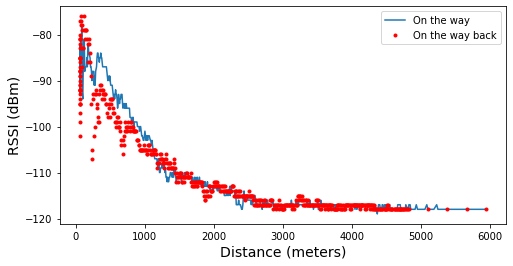

In [ ]:
# Definir aqui o fator de espalhamento
fator_espalhamento = 7

figura, ax = plt.subplots(figsize=(8, 4))

i = fator_espalhamento - 7
arrRSSI = np.array(lista_FE[i]["RSSI"])
arrDistancia = np.array(lista_FE[i]["Distancia"])

menorIda = 0
maiorIda = lista_maior[i][0] + 1

menorVolta = lista_maior[i][0]
maiorVolta = len(lista_FE[i]) + 1

yIda = arrRSSI[menorIda:maiorIda]
xIda = arrDistancia[menorIda:maiorIda]

yVolta = arrRSSI[menorVolta:maiorVolta]
xVolta = arrDistancia[menorVolta:maiorVolta]

ax.plot(xIda, yIda, label='On the way')
# ax.plot(xIda, yIda, label='Ida')
ax.plot(xVolta, yVolta, 'r.', label='On the way back')
# ax.plot(xVolta, yVolta, 'r.', label='Volta')
ax.set_xlabel('Distance (meters)', size=14)
# ax.set_xlabel('Distância (metros)', size=14)
ax.set_ylabel('RSSI (dBm)', size=14)
# ax.set_title('Spread Factor ' + str(i + 7), size=12)
# ax.set_title('Fator de Espalhamento ' + str(i + 7), size=15)
ax.legend()
figura.savefig('FE{}.png'.format(i + 7))
figura.show()

### Todos os fatores de espalhamento

Imprime os 6 gráficos dos fatores de espalhamento de 7 a 12 na ida e na volta. Onde o RSSI está em função da distância.

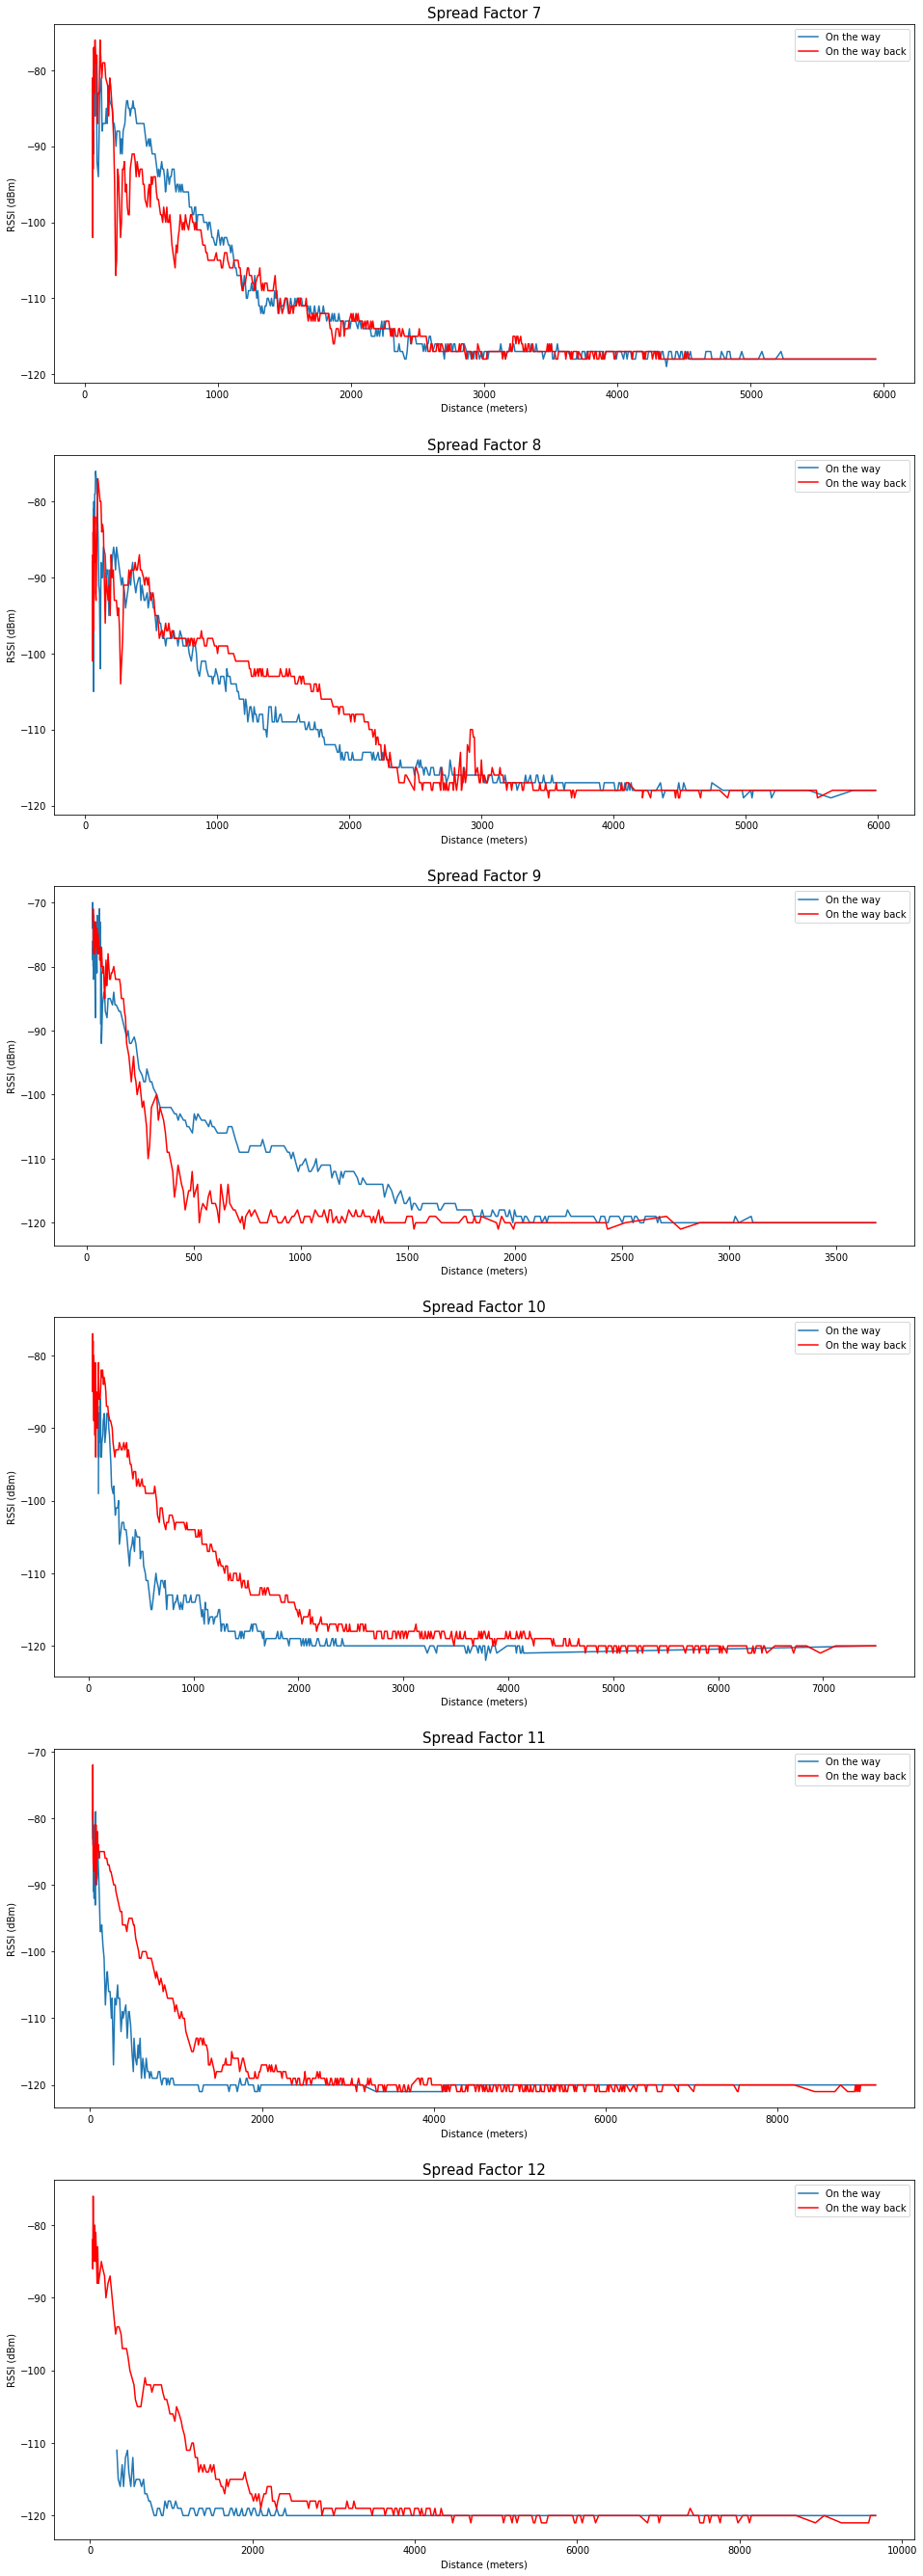

In [ ]:
figura, ax = plt.subplots(nrows= 6, ncols=1, figsize=(16, 48))

for i in range(6):
  arrRSSI = np.array(lista_FE[i]["RSSI"])
  arrDistancia = np.array(lista_FE[i]["Distancia"])

  menorIda = 0
  maiorIda = lista_maior[i][0] + 1

  menorVolta = lista_maior[i][0]
  maiorVolta = len(lista_FE[i]) + 1

  yIda = arrRSSI[menorIda:maiorIda]
  xIda = arrDistancia[menorIda:maiorIda]

  yVolta = arrRSSI[menorVolta:maiorVolta]
  xVolta = arrDistancia[menorVolta:maiorVolta]

  ax[i].plot(xIda, yIda, label='On the way')
  # ax[i].plot(xIda, yIda, label='Ida')
  ax[i].plot(xVolta, yVolta, 'r', label='On the way back')
  # ax[i].plot(xVolta, yVolta, 'r', label='Volta')
  ax[i].set_xlabel('Distance (meters)')
  # ax[i].set_xlabel('Distância (metros)')
  ax[i].set_ylabel('RSSI (dBm)')
  ax[i].set_title('Spread Factor ' + str(i + 7), size=15)
  # ax[i].set_title('Fator de Espalhamento ' + str(i + 7), size=15)
  ax[i].legend()

figura.show()

### F.E. na ida

Imprime os seis fatores de espalhamento na ida em um único gráfico

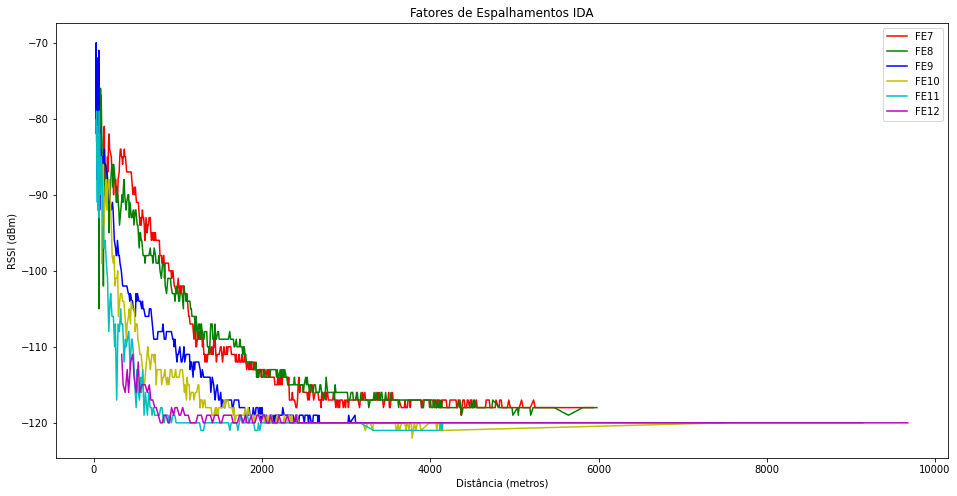

In [ ]:
fig, ax = plt.subplots(figsize = (16, 8))

cores = ['r', 'g', 'b', 'y', 'c', 'm']

for i in range(6):
  arrRSSI = np.array(lista_FE[i]["RSSI"])
  arrDistancia = np.array(lista_FE[i]["Distancia"])

  menorIda = 0
  maiorIda = lista_maior[i][0] + 1

  yIda = arrRSSI[menorIda:maiorIda]
  xIda = arrDistancia[menorIda:maiorIda]

  ax.plot(xIda, yIda, cores[i], label='FE{}'.format(i + 7))

ax.set_xlabel('Distância (metros)')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('Fatores de Espalhamentos IDA')
ax.legend()
fig.savefig("FE_IDA.png")
fig.show()

### F.E. na volta

Imprime os seis fatores de espalhamento na volta em um único gráfico

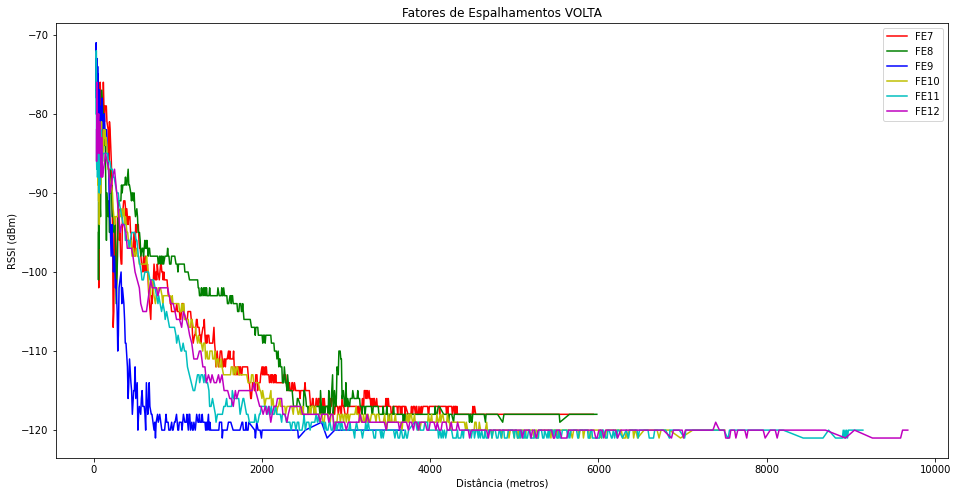

In [ ]:
fig, ax = plt.subplots(figsize = (16, 8))

cores = ['r', 'g', 'b', 'y', 'c', 'm']

for i in range(6):
  arrRSSI = np.array(lista_FE[i]["RSSI"])
  arrDistancia = np.array(lista_FE[i]["Distancia"])

  menorVolta = lista_maior[i][0]
  maiorVolta = len(arrRSSI) + 1

  yVolta = arrRSSI[menorVolta:maiorVolta]
  xVolta = arrDistancia[menorVolta:maiorVolta]

  ax.plot(xVolta, yVolta, cores[i], label='FE{}'.format(i + 7))

ax.set_xlabel('Distância (metros)')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('Fatores de Espalhamentos VOLTA')
ax.legend()
fig.savefig("FE_VOLTA.png")
fig.show()

### Histogramas

In [ ]:
from datetime import datetime
from datetime import timedelta

lista_nome = []
lista_sucesso = []
lista_bytes = []

for i in range(6):
  # i = 1
  lista_nome.append('FE{}'.format(i+7))
  subLista = lista_FE[i]
  
  #Lista com distâncias maiores que 150 metros
  maior150 = pd.DataFrame(columns=['Hora_Recepcao','Contador'])

  for j in range(len(subLista)):
    if (subLista["Distancia"][j] > 350): #Se a distância for maior do que 150 metros
      maior150 = maior150.append(
          {
            'Hora_Recepcao': subLista["Hora_Recepcao"][j],
            'Contador': subLista["Contador"][j],
          }, ignore_index=True)

  ant = 0
  perdidos = 0

  for j in range(1, len(maior150)): # Verifica quantos pacotes foram perdidos
    sub = maior150["Contador"][j] - maior150["Contador"][ant]
    if (sub < 0):
      sub = sub * (-1)
    if (sub < 150 and maior150["Contador"][j] > maior150["Contador"][ant]):
      verifica = sub - 1
      perdidos += verifica
      ant = j

  qtd = maior150["Contador"][len(maior150) - 1] - maior150["Contador"][0]
  sucesso = qtd - perdidos # Quantidade de pacotes entregues com sucesso
  taxaSucesso = round( (100 * sucesso) / qtd, 2)
  lista_sucesso.append(taxaSucesso)

  if (type(maior150["Hora_Recepcao"][0]) == pd._libs.tslibs.timestamps.Timestamp):
    tempoIni = maior150["Hora_Recepcao"][0]
    tempoFin = maior150["Hora_Recepcao"][len(maior150) - 1]
  else: 
    tempoIni = datetime.strptime(maior150["Hora_Recepcao"][0], '%H:%M:%S.%f')
    tempoFin = datetime.strptime(maior150["Hora_Recepcao"][len(maior150) - 1], '%H:%M:%S.%f')
  
  if (tempoFin.hour == 0): # Se passou de meia noite
    tempoFin = tempoFin + timedelta(days=1)

  tempo_dif = tempoFin - tempoIni # Intervalo de tempo em segundos
  taxa_bytesSegundo = (19 * sucesso) / tempo_dif.seconds
  lista_bytes.append(taxa_bytesSegundo)

#### Taxa de entrega de pacotes

É a porcentagem dos pacotes que foram entregues com sucesso em cada fator de espalhamento. Ou seja, os pacotes que não se perderam no envio.

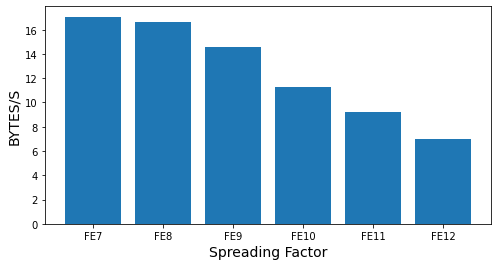

In [ ]:
figura3, ax_3 = plt.subplots(figsize=(8, 4))
ax_3.bar(lista_nome, lista_bytes)
# ax_3.set_title('Rendimento Médio', size=18)
# ax_3.set_title('Average Throughput', size=18)
ax_3.set_ylabel('BYTES/S', size=14)
ax_3.set_xlabel('Spreading Factor', size=14)
# ax_3.set_xlabel('Fator de Espalhamento', size=14)
figura3.savefig("Taxa_bytes.png")
figura3.show()

#### Rendimento médio dos pacotes


O rendimento médio dos pacotes é a taxa de bytes por segundo em cada fator de espalhamento

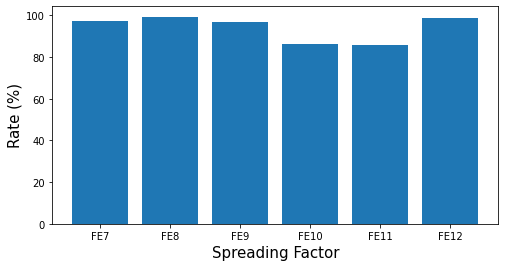

In [ ]:
figura2, ax_2 = plt.subplots(figsize=(8, 4))
ax_2.bar(lista_nome, lista_sucesso)
# ax_2.set_title('Package delivery rate', size=17)
# ax_2.set_title('Taxa de entrega de pacotes', size=17)
ax_2.set_ylabel('Rate (%)', size=15)
# ax_2.set_ylabel('Taxa (%)', size=15)
ax_2.set_xlabel('Spreading Factor', size=15)
# ax_2.set_xlabel('Fator de Espalhamento', size=15)
figura2.savefig("Sucesso.png")
figura2.show()